# Run cell below to set up all shot data

In [424]:
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC

data = []
with open('shot_logs.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        for row in reader:
            data.append(row)

categories = ['game_id','matchup','location','win/lose','final_margin','shot_number','period','game_clock',
             'shot_clock','dribbles','touch_time','shot_dist','pts_type','shot_result','closest_def_name',
             'closest_def_id','closest_def_dist','fgm','pts','player_name', 'player_id']

shot_dict = {}
for i in range(len(data)):
    shot_dict[i] = dict(zip(categories, data[i]))

labels = [int(shot_dict[i]['fgm']) for i in range(len(data))]

# Cleaning Data

In [425]:
# Cleaning shot_dict for categorical data
for i in range(len(data)):
    if shot_dict[i]['shot_clock'] == '':
        shot_dict[i]['shot_clock'] = 0
    if shot_dict[i]['dribbles'] == '':
         shot_dict[i]['dribbles'] = 0
            
    if shot_dict[i]['location'] == 'A':
        shot_dict[i]['location'] = 0
    else:
        shot_dict[i]['location'] = 1
        
    if shot_dict[i]['win/lose'] == 'L':
        shot_dict[i]['win/lose'] = 0
    else:
        shot_dict[i]['win/lose'] = 1
    
    game_sec = 60 - float(shot_dict[i]['game_clock'].split(':')[1])
    if game_sec == 0:
        game_min = 12 - float(shot_dict[i]['game_clock'].split(':')[0])
    else:
        game_min = 12 - float(shot_dict[i]['game_clock'].split(':')[0]) - 1
    shot_dict[i]['time_into_game'] = (float(shot_dict[i]['period'])-1)*12*60 + game_min*60 + game_sec

In [426]:
shot_dict[3]

{'closest_def_dist': '3.4',
 'closest_def_id': '203900',
 'closest_def_name': 'Brown, Markel',
 'dribbles': '2',
 'fgm': '0',
 'final_margin': '24',
 'game_clock': '11:47',
 'game_id': '21400899',
 'location': 0,
 'matchup': 'MAR 04, 2015 - CHA @ BKN',
 'period': '2',
 'player_id': '203148',
 'player_name': 'brian roberts',
 'pts': '0',
 'pts_type': '2',
 'shot_clock': '10.3',
 'shot_dist': '17.2',
 'shot_number': '4',
 'shot_result': 'missed',
 'time_into_game': 733.0,
 'touch_time': '1.9',
 'win/lose': 1}

# Ratio plots

In [427]:
def createPlot(category):
    cat_data = [float(shot_dict[i][category]) for i in range(len(data))]
    cat_zip = list(zip(cat_data,labels))
    made = [d[0] for d in cat_zip if d[1] == 1]
    x_axis = list(range(int(min(made)-1),int(max(made)+2)))
    made_counts, _= np.histogram(made,x_axis)
    notmade = [d[0] for d in cat_zip if d[1] == 0]
    notmade_counts, _= np.histogram(notmade,x_axis)

    ratio = np.divide(made_counts, made_counts+notmade_counts)
    return ratio, x_axis[:-1]

In [488]:
categories = ['dribbles', 'shot_clock', 'shot_dist', 'pts_type','closest_def_dist', 'touch_time', 'location',
             'win/lose', 'period', 'final_margin', 'time_into_game']

/Users/ryanle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


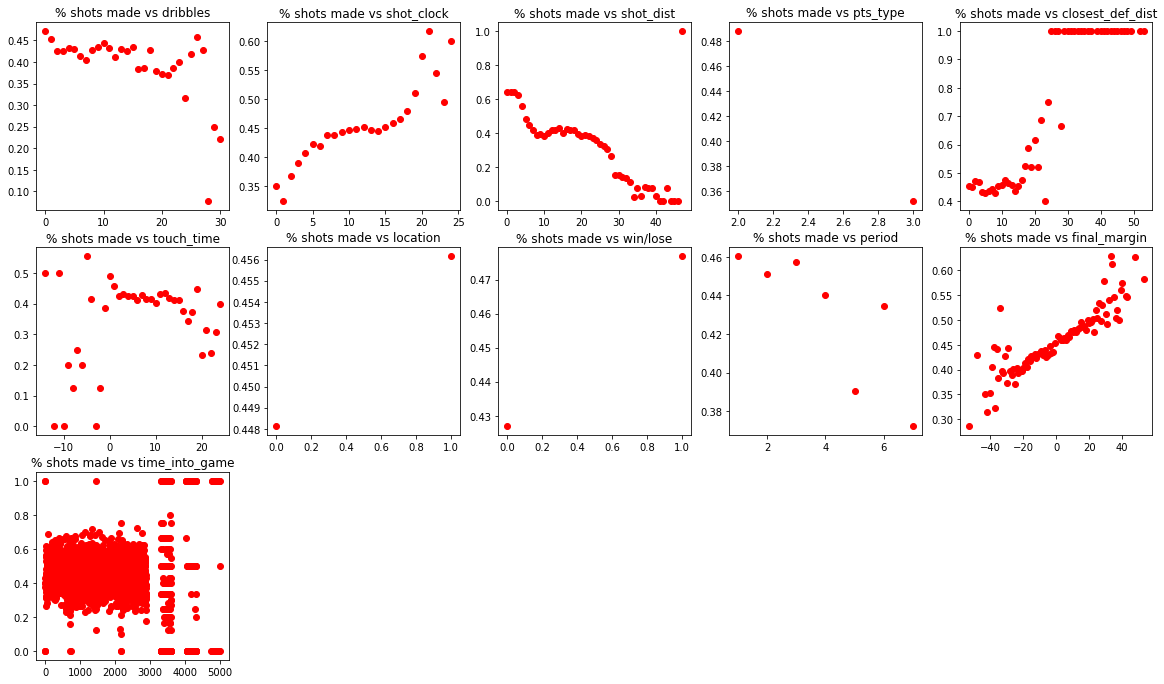

In [489]:
fig = plt.figure(figsize=(20,20))
for i in range(len(categories)):
    ratio, x_axis = createPlot(categories[i])
    ax1 = fig.add_subplot(len(categories)/2,len(categories)/2, i+1)
    plt.title("% shots made vs " + categories[i])
    plt.plot(x_axis, ratio, 'ro')

# Player Analysis (run cell below to setup player data)

In [67]:
player_names = set([shot_dict[i]['player_name'] for i in range(len(data))])
player_ids = set([shot_dict[i]['player_id'] for i in range(len(data))])

name_to_id = {}
id_to_name = {}
for i in range(len(data)):
    name_to_id[shot_dict[i]['player_name']] = shot_dict[i]['player_id']
    id_to_name[shot_dict[i]['player_id']] = shot_dict[i]['player_name']

player_data = []
with open('players.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        for row in reader:
            player_data.append(row)

# Making names lower case to keep uniform
for d in player_data:
    d[0] = d[0].lower()

# Converting the positions to numbers ([:2] is to get primary position for those with 2 pos)
for d in player_data:
    if d[1][:2] == "PG":
        d[1] = 1
    elif d[1][:2] == "SG":
        d[1] = 2
    elif d[1][:2] == "SF":
        d[1] = 3
    elif d[1][:2] == "PF":
        d[1] = 4
    elif d[1][:2] == "C":
        d[1] = 5

player_cats = ['player','pos','fg','3p','2p','efg','ppg']

player_dict = {} # Dictionary of players with player id's as keys
for d in player_data:
    if d[0] in player_names:
        pid = name_to_id[d[0]]
        player_dict[pid] = dict(zip(player_cats, d))

def getPlayerStats(name):
    return player_dict[name_to_id[name]]

In [275]:
len(player_dict.keys())

258

In [68]:
pids = list(player_ids)
ppg = []
fg = []
fg3 = []
efg = []
pos = []
for pid in pids:
    if pid in set(player_dict.keys()):
        if player_dict[pid]['ppg'] == "":
            ppg.append(0)
        else:
            ppg.append(float(player_dict[pid]['ppg']))
        if player_dict[pid]['fg'] == "":
            fg.append(0)
        else:
            fg.append(float(player_dict[pid]['fg']))
        if player_dict[pid]['3p'] == "":
            fg3.append(0)
        else:
            fg3.append(float(player_dict[pid]['3p']))
        if player_dict[pid]['efg'] == "":
            efg.append(0)
        else:
            efg.append(float(player_dict[pid]['efg']))
        if player_dict[pid]['pos'] == "":
            pos.append(0)
        else:
            pos.append(float(player_dict[pid]['pos']))

In [70]:
# Efg data for all players
efg_std = np.std(efg)
efg_mean = np.mean(efg)
for pid in pids:
    if pid in player_dict.keys():
        player_dict[pid]['efg_zscore'] = (float(player_dict[pid]['efg']) - efg_mean) / efg_std

In [209]:
# Separating efg per position
efgs_pos = [[] for _ in range(5)]
for key in player_dict.keys():
    pos = player_dict[key]['pos']
    efgs_pos[pos-1].append(float(player_dict[key]['efg']))

efgs_mean = [np.mean(d) for d in efgs_pos]
efgs_std = [np.std(d) for d in efgs_pos]

for pid in pids:
    if pid in player_dict.keys():
        pos = player_dict[key]['pos']
        player_dict[pid]['efg_zscore_pos'] = (float(player_dict[pid]['efg']) - efgs_mean[pos-1]) / efgs_std[pos-1]

In [221]:
getPlayerStats('bradley beal')

{'2p': '0.434',
 '3p': '0.409',
 'efg': '0.489',
 'efg_zscore': -0.2429523969408064,
 'efg_zscore_pos': -0.5123692473395512,
 'fg': '0.427',
 'player': 'bradley beal',
 'pos': 2,
 'ppg': '15.3'}

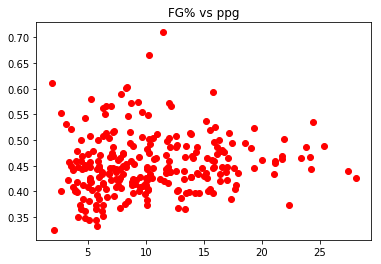

In [184]:
plt.title("FG% vs ppg")
plt.plot(ppg, fg, 'ro')

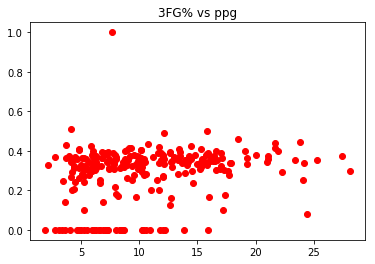

In [185]:
plt.title("3FG% vs ppg")
plt.plot(ppg, fg3, 'ro')

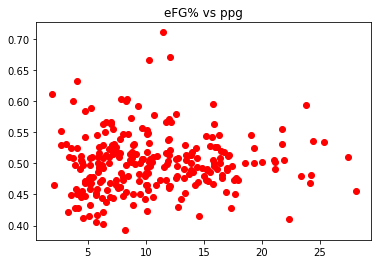

In [186]:
plt.title("eFG% vs ppg")
plt.plot(ppg, efg, 'ro')

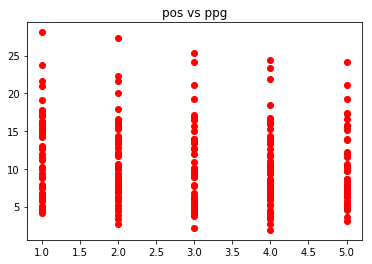

In [45]:
plt.title("pos vs ppg")
plt.plot(pos, ppg, 'ro')

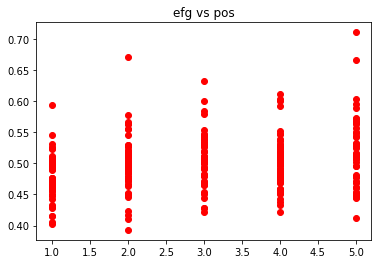

In [44]:
plt.title("efg vs pos")
plt.plot(pos, efg, 'ro')

[('0.458', 1.0),
 ('0.458', 0.0),
 ('0.458', 0.0),
 ('0.458', 0.0),
 ('0.458', 0.0),
 ('0.458', 0.0),
 ('0.458', 0.0),
 ('0.458', 1.0),
 ('0.458', 0.0),
 ('0.458', 0.0)]

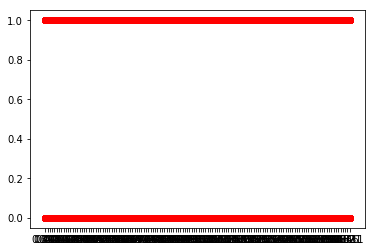

In [166]:
# Comparing made shots to efg
efg_made = []
for i in range(len(data)):
    player_name = shot_dict[i]['player_name']
    if name_to_id[player_name] in player_dict.keys():
        player_efg = getPlayerStats(player_name)['efg']
        made = float(shot_dict[i]['fgm'])
        efg_made.append((player_efg,made))
        
plt.plot([d[0] for d in efg_made], [d[1] for d in efg_made], 'ro')
efg_made[:10]

In [79]:
getPlayerStats('stephen curry')

{'2p': '0.528',
 '3p': '0.443',
 'efg': '0.594',
 'efg_zscore': 2.002554403852906,
 'fg': '0.487',
 'player': 'stephen curry',
 'pos': 1,
 'ppg': '23.8'}

# Data & Feature Funcs

In [375]:
# Sampling training sets and test sets
shot_list = list(zip(shot_dict.keys(),shot_dict.values()))
random.shuffle(shot_list)

train_set = shot_list[:int(len(shot_list)*(0.95))]
test_set = shot_list[int(len(shot_list)*(0.95)):]

In [322]:
def feature1(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['touch_time']) if datum['touch_time'] != "" else 0)
    feat.append(float(datum['final_margin']) if datum['touch_time'] != "" else 0)
    
    return feat

In [323]:
# Including the z-score of the shooters efg to all players
def feature2(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['touch_time']) if datum['touch_time'] != "" else 0)
    feat.append(float(datum['final_margin']) if datum['touch_time'] != "" else 0)
    if name_to_id[datum['player_name']] in player_dict.keys():
        feat.append(getPlayerStats(datum['player_name'])['efg_zscore'])
    else:
        feat.append(0)
    
    return feat

In [461]:
getPlayerStats('stephen curry')

{'2p': '0.528',
 '3p': '0.443',
 'efg': '0.594',
 'efg_zscore': 2.002554403852906,
 'efg_zscore_pos': 1.2873049417143183,
 'fg': '0.487',
 'player': 'stephen curry',
 'pos': 1,
 'ppg': '23.8'}

In [530]:
# Using the z-score of the shooters efg relative to his postiion
def feature3(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['touch_time']) if datum['touch_time'] != "" else 0)
    feat.append(float(datum['final_margin']) if datum['touch_time'] != "" else 0)
    if name_to_id[datum['player_name']] in player_dict.keys():
        feat.append(getPlayerStats(datum['player_name'])['efg_zscore_pos'])
    else:
        feat.append(0)
    
    return feat

In [468]:
# Using the z-score of the shooters efg relative to his postiion
def feature30(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['touch_time']) if datum['touch_time'] != "" else 0)
    feat.append(float(datum['final_margin']) if datum['touch_time'] != "" else 0)
    if name_to_id[datum['player_name']] in player_dict.keys():
        feat.append(float(getPlayerStats(datum['player_name'])['efg']))
    else:
        feat.append(0)
    return feat

In [420]:
def feature4(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) - 10 if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['touch_time']) if datum['touch_time'] != "" else 0)
    feat.append(float(datum['final_margin']) if datum['touch_time'] != "" else 0)
    feat.append(float(datum['dribbles']) if datum['dribbles'] != "" else 0)
    feat.append(float(datum['time_into_game']) if datum['time_into_game'] != "" else 0)
    feat.append(float(datum['win/lose']) if datum['win/lose'] != "" else 0)
    feat.append(float(datum['location']) if datum['location'] != "" else 0)
    feat.append(datum['player_id'])
    
    if name_to_id[datum['player_name']] in player_dict.keys():
        feat.append(getPlayerStats(datum['player_name'])['efg_zscore'])
    else:
        feat.append(0)
    if name_to_id[datum['player_name']] in player_dict.keys():
        feat.append(getPlayerStats(datum['player_name'])['efg_zscore_pos'])
    else:
        feat.append(0)
        
    return feat

In [358]:
def feature5(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['closest_def_dist']) if datum['closest_def_dist'] != "" else 0)
    
    return feat

# Model Running

In [531]:
feature_func = feature3

# Creating features
X_train = [feature_func(d[1]) for d in train_set]
y_train = [float(d[1]['fgm']) for d in train_set]

X_test = [feature_func(d[1]) for d in test_set]
y_test = [float(d[1]['fgm']) for d in test_set]

In [532]:
# Baseline: Just pick randomly
test_preds = []
for x in X_test:
    test_preds.append(random.randint(0,1))
    
test_acc = sum([1 for a,b in zip(y_test,test_preds) if a==b]) / len(y_test)
print("Test accuracy: ", test_acc)

Test accuracy:  0.5012492192379763


In [533]:
# Logistic Regression with l1 norm
clf = LogisticRegression(penalty='l1').fit(X_train, y_train)

train_preds = clf.predict(X_train)
train_acc = sum([1 for a,b in zip(y_train,train_preds) if a==b]) / len(y_train)

test_preds = clf.predict(X_test)
test_acc = sum([1 for a,b in zip(y_test,test_preds) if a==b]) / len(y_test)

print("Train accuracy: ", train_acc, "Test accuracy: ", test_acc)

Train accuracy:  0.6041918382443595 Test accuracy:  0.6122735790131169


In [534]:
# Logistic Regression
clf = LogisticRegression(penalty = 'l2').fit(X_train, y_train)

train_preds = clf.predict(X_train)
train_acc = sum([1 for a,b in zip(y_train,train_preds) if a==b]) / len(y_train)

test_preds = clf.predict(X_test)
test_acc = sum([1 for a,b in zip(y_test,test_preds) if a==b]) / len(y_test)

print("Train accuracy: ", train_acc, "Test accuracy: ", test_acc)

Train accuracy:  0.6041671803723339 Test accuracy:  0.6124297314178638


In [535]:
clf.coef_

array([[ 0.12938311,  0.02037905, -0.04258973, -0.03382166,  0.00899582,
         0.11260216]])

In [536]:
# SVM with Linear Kernel
clf = LinearSVC(C=0.01)
clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)
train_acc = sum([1 for a,b in zip(y_train,train_preds) if a==b]) / len(y_train)

test_preds = clf.predict(X_test)
test_acc = sum([1 for a,b in zip(y_test,test_preds) if a==b]) / len(y_test)

print("Train accuracy: ", train_acc, "Test accuracy: ", test_acc)

Train accuracy:  0.6040521103028809 Test accuracy:  0.6122735790131169


In [537]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth=20)
# Train the model on training data
rf.fit(X_train, y_train)

train_preds = rf.predict(X_train)
train_acc = sum([1 for a,b in zip(y_train,train_preds) if a==b]) / len(y_train)

test_preds = rf.predict(X_test)
test_acc = sum([1 for a,b in zip(y_test,test_preds) if a==b]) / len(y_test)

print("Train accuracy: ", train_acc, "Test accuracy: ", test_acc)

Train accuracy:  0.8896395841038919 Test accuracy:  0.613054341036852


In [522]:
print(getPlayerStats('lebron james'), "\n", getPlayerStats('quincy acy'))

{'player': 'lebron james', 'pos': 3, 'fg': '0.488', '3p': '0.354', '2p': '0.536', 'efg': '0.535', 'ppg': '25.3', 'efg_zscore': 0.7407934395973925, 'efg_zscore_pos': 0.2760594450078591} 
 {'player': 'quincy acy', 'pos': 4, 'fg': '0.459', '3p': '0.3', '2p': '0.494', 'efg': '0.486', 'ppg': '5.9', 'efg_zscore': -0.3071097341063411, 'efg_zscore_pos': -0.5637885098839476}


In [439]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(categories, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: shot_dist            Importance: 0.32
Variable: shot_clock           Importance: 0.26
Variable: pts_type             Importance: 0.21
Variable: closest_def_dist     Importance: 0.2
Variable: dribbles             Importance: 0.0


[None, None, None, None, None]